## Data Loading

We will first load the dataset and add column names to the dataset

In [1]:
import pandas as pd
import numpy as np
from dateutil import parser, tz
from datetime import datetime

In [3]:
!unzip -qq "/content/UserLog.csv.zip"

In [4]:
## import dataset
pd.options.mode.chained_assignment = None  # default='warn'
data_df = pd.read_csv("./UserLog.csv", parse_dates=True)

In [5]:
data_df.columns = ["Time_stamp", "Event", "Cluster_name", "duration", "num_students"]
data_df.head()

,Time_stamp,Event,Cluster_name,duration,num_students
0,Fri Jan 01 00:00:00 GMT 2010,LOGIN,LAKE,10058927,2
1,Fri Jan 01 00:00:00 GMT 2010,LOGIN,SIDE,6868990,3
2,Fri Jan 01 00:00:00 GMT 2010,LOGIN,LAKE,2997017,4
3,Fri Jan 01 00:00:00 GMT 2010,LOGIN,LAKE,8919800,5
4,Fri Jan 01 00:00:00 GMT 2010,LOGIN,LAKE,4426803,6


## Data Preprocessing

We will convert the time stamp to a numerical value to make it easier for us to predict the next time stamp.

In [6]:
import dateutil.parser
import dateutil.tz


## Splitting the time stamp to create additional features

data_df["Day"] = data_df["Time_stamp"].apply(lambda x: x.split(' ')[0])
data_df["Month"] = data_df["Time_stamp"].apply(lambda x: x.split(' ')[1])
data_df["Date"] = data_df["Time_stamp"].apply(lambda x: np.int64(x.split(' ')[2]))
data_df["Hour"] = data_df["Time_stamp"].apply(lambda x: np.int64(x.split(' ')[3].split(':')[0]))
data_df["Minute"] = data_df["Time_stamp"].apply(lambda x: np.int64(x.split(' ')[3].split(':')[1]))
data_df["Second"] = data_df["Time_stamp"].apply(lambda x: np.int64(x.split(' ')[3].split(':')[2]))


## Converting time stamp to consistent format
BST = dateutil.tz.gettz('Europe/London')
# dateutil.parser.parse('25-Oct-20 12:00:00 AM BST', tzinfos={'BST': BST})
data_df['Time_stamp'] = data_df['Time_stamp'].apply(lambda x: dateutil.parser.parse(x, tzinfos={'BST': BST}))


## creating target variable by converting time stamp to a number
data_df['Time_stamp_s'] = data_df['Time_stamp'].apply(lambda x: pd.Timestamp.timestamp(pd.Timestamp(x)))
data_df_time = data_df.set_index('Time_stamp')
data_df_time.head()


,Event,Cluster_name,duration,num_students,Day,Month,Date,Hour,Minute,Second,Time_stamp_s
Time_stamp,,,,,,,,,,,
2010-01-01 00:00:00+00:00,LOGIN,LAKE,10058927,2,Fri,Jan,1,0,0,0,1.262304e+09
2010-01-01 00:00:00+00:00,LOGIN,SIDE,6868990,3,Fri,Jan,1,0,0,0,1.262304e+09
2010-01-01 00:00:00+00:00,LOGIN,LAKE,2997017,4,Fri,Jan,1,0,0,0,1.262304e+09
2010-01-01 00:00:00+00:00,LOGIN,LAKE,8919800,5,Fri,Jan,1,0,0,0,1.262304e+09
2010-01-01 00:00:00+00:00,LOGIN,LAKE,4426803,6,Fri,Jan,1,0,0,0,1.262304e+09


Splitting the data into train, test and val. Last 100 rows will act as the test set and the remaining will be used for training and validation purpose.

In [7]:
## Splitting the dataset into train, val and test

test_df = data_df_time.tail(150)

data_df_time.drop(test_df.index, inplace = True)
n = len(data_df_time)
train_df = data_df_time[0:int(n*0.7)]
val_df = data_df_time[int(n*0.7):]


In [8]:
train_df.shape, val_df.shape, test_df.shape

((1721640, 11), (737847, 11), (150, 11))

Now that our dataset is split into train, test and validation sets, we can perform Scaling and Encoding to numerical and categorical variables in the dataset.

In [9]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

scaler_duration = MinMaxScaler()
scaler_num_students = MinMaxScaler()
scaler_time_stamp = MinMaxScaler()
scaler_hour = MinMaxScaler()
scaler_minute = MinMaxScaler()
scaler_sec = MinMaxScaler()

label_enc_event = LabelEncoder()
label_enc_cluster = LabelEncoder()
label_enc_day = LabelEncoder()

def scale_encode_data(data_mod, train_data = True):

    data = data_mod.copy()
    if train_data:
        data['duration'] = scaler_duration.fit_transform(data[['duration']])
        data['num_students'] = scaler_num_students.fit_transform(data[['num_students']])
        data['Time_stamp_s'] = scaler_time_stamp.fit_transform(data[['Time_stamp_s']])
        data['Hour'] = scaler_hour.fit_transform(data[['Hour']])
        data['Minute'] = scaler_minute.fit_transform(data[['Minute']])
        data['Second'] = scaler_sec.fit_transform(data[['Second']])

        data['Event'] = label_enc_event.fit_transform(data['Event'])
        data['Cluster_name'] = label_enc_cluster.fit_transform(data['Cluster_name'])
        data['Day'] = label_enc_day.fit_transform(data['Day'])

        return data

    data['duration'] = scaler_duration.transform(data[['duration']])
    data['num_students'] = scaler_num_students.transform(data[['num_students']])
    data['Time_stamp_s'] = scaler_time_stamp.transform(data[['Time_stamp_s']])
    data['Hour'] = scaler_hour.transform(data[['Hour']])
    data['Minute'] = scaler_minute.transform(data[['Minute']])
    data['Second'] = scaler_sec.transform(data[['Second']])

    data['Event'] = label_enc_event.transform(data['Event'])
    data['Cluster_name'] = label_enc_cluster.transform(data['Cluster_name'])
    data['Day'] = label_enc_day.transform(data['Day'])

    return data


train_df = scale_encode_data(train_df, train_data=True)
val_df = scale_encode_data(val_df, train_data=False)
test_df = scale_encode_data(test_df, train_data=False)




## Task 1: Predicting Time stamps for next 100 Events

For the first task, we have to predict the time stamp of the next 100 events. We will first choose relevant columns for this task. Even though we splitted the time stamp into Days, Month and Hour variables before, we won't be using those. Those variables did not produce significant improvements in the performance of the model and thus, its better to use variables such as Cluster name, Number of Students and Duration.

In [10]:
## Extract features and targets from dataset

# train_df_time = train_df[['Day', 'Hour', 'Second', 'Minute', 'Time_stamp_s']]
# train_df_time_target = train_df[['Time_stamp_s']]
# val_df_time = val_df[['Day', 'Hour', 'Second', 'Minute', 'Time_stamp_s']]
# val_df_time_target = val_df[['Time_stamp_s']]
# test_df_time = test_df[['Day', 'Hour', 'Second', 'Minute', 'Time_stamp_s']]
# test_df_time_target = test_df[['Time_stamp_s']]


train_df_time = train_df[['Cluster_name','num_students', 'duration', 'Time_stamp_s']]
train_df_time_target = train_df[['Time_stamp_s']]
val_df_time = val_df[['Cluster_name','num_students', 'duration', 'Time_stamp_s']]
val_df_time_target = val_df[['Time_stamp_s']]
test_df_time = test_df[['Cluster_name','num_students', 'duration', 'Time_stamp_s']]
test_df_time_target = test_df[['Time_stamp_s']]



In [11]:
train_df_time.shape, train_df_time_target.shape, test_df_time.shape, test_df_time_target.shape

((1721640, 4), (1721640, 1), (150, 4), (150, 1))

Below function will convert the given dataset into a format that can be fed into Time series neural network. It accepts additional parameters such as sequence length, number of future time steps to be predicted and name of the target column. For all 3 tasks, we will use a sequence length of 50 and future time step prediction of 1. A sequence consists of values of previous time stamps, and since we are using multiple variables, values of previous time stamps for each variable is part of the sequence. This is also referred as window size.

Initial experiments made us realise that the dataset is too large and a larger sequence length causes model to take longer time to train. Additionally, creation of a time series dataset also takes additional time for a large dataset.

In [12]:
def create_time_series_dataset(data, sequence_length, future_steps, col_name):
    sequences = []
    targets = []
    target_df = data[col_name]
    for i in range(len(data) - sequence_length - future_steps + 1):
        sequence = data[i:i + sequence_length]
        target = target_df[i + sequence_length:i + sequence_length + future_steps]
        sequences.append(sequence)
        targets.append(target)

    return np.array(sequences), np.array(targets)

In [13]:
# target_feature_index = train_df.columns.get_loc('Time_stamp_s')

train_df_X, train_df_y = create_time_series_dataset(train_df_time, 50, 1,'Time_stamp_s')
test_df_X, test_df_y = create_time_series_dataset(test_df_time, 50, 1,'Time_stamp_s')
val_df_X, val_df_y = create_time_series_dataset(val_df_time, 50, 1,'Time_stamp_s')


Below shapes of the dataset are in the format (Batch, Window_size, number_features). This is the format in which data will be fed to neural network.

In [14]:
train_df_X.shape, train_df_y.shape, test_df_X.shape, test_df_y.shape, val_df_X.shape, val_df_y.shape

((1721590, 50, 4),
 (1721590, 1),
 (100, 50, 4),
 (100, 1),
 (737797, 50, 4),
 (737797, 1))

## Model Building



We have designed the simplest neural network architecture for time series problem. Our model consists of only 1 LSTM layer with 50 units and 1 Dense layer with 1 output unit. LSTMs, or Long Short-Term Memory networks, are a type of recurrent neural network (RNN) architecture designed to address the challenges of learning long-term dependencies in sequential data. We resorted to such a simple architecture due to the fact that complex architectures did not provide significant improvements in results and instead was taking longer time to train. The trade off between accuracy and training time was quite evident in this task.

In [15]:
import tensorflow as tf

MAX_EPOCHS = 20

def compile_and_fit(model, model_name, patience=4):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(train_df_X, train_df_y, epochs=MAX_EPOCHS,
                      validation_data=(val_df_X, val_df_y),
                      callbacks=[early_stopping])
  model.save_weights(f'./time_Series/lstm_model_{model_name}.h5')
  return history

In [19]:

multi_lstm_model_time = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(50, return_sequences=False),
    # Shape => [batch, out_steps*features].
    # tf.keras.layers.Dense(100*1,
    #                       kernel_initializer=tf.initializers.zeros()),
    # # Shape => [batch, out_steps, features].
    # tf.keras.layers.Reshape([100, 1])
    tf.keras.layers.Dense(1)
])

history = compile_and_fit(multi_lstm_model_time, 'multi_lstm_model_time')

Epoch 1/20
53800/53800 [==============================] - 298s 5ms/step - loss: 2.1810e-04 - mean_absolute_error: 0.0029 - val_loss: 3.4447e-05 - val_mean_absolute_error: 0.0047
Epoch 2/20
53800/53800 [==============================] - 293s 5ms/step - loss: 2.3908e-06 - mean_absolute_error: 0.0010 - val_loss: 6.2024e-05 - val_mean_absolute_error: 0.0059
Epoch 3/20
53800/53800 [==============================] - 294s 5ms/step - loss: 1.1895e-06 - mean_absolute_error: 7.3664e-04 - val_loss: 8.6930e-05 - val_mean_absolute_error: 0.0065
Epoch 4/20
53800/53800 [==============================] - 294s 5ms/step - loss: 7.8487e-07 - mean_absolute_error: 5.5257e-04 - val_loss: 3.5350e-05 - val_mean_absolute_error: 0.0040
Epoch 5/20
53800/53800 [==============================] - 293s 5ms/step - loss: 8.3398e-07 - mean_absolute_error: 4.9977e-04 - val_loss: 2.9149e-05 - val_mean_absolute_error: 0.0037
Epoch 6/20
53800/53800 [==============================] - 293s 5ms/step - loss: 5.9196e-07 - mean_

In [20]:
# multi_lstm_model_time.load_weights("./lstm_model_multi_lstm_model_time.h5")
# multi_lstm_model_time.compile(loss=tf.keras.losses.MeanSquaredError(),
                # optimizer=tf.keras.optimizers.Adam(),
                # metrics=[tf.keras.metrics.MeanAbsoluteError()])
mse_time, mae_time = multi_lstm_model_time.evaluate(test_df_X, test_df_y)

print(f"Mean Squared Error: {mse_time}\n")
print(f"Mean Absolute Error: {mae_time}")

4/4 [==============================] - 0s 4ms/step - loss: 4.6016e-04 - mean_absolute_error: 0.0208
Mean Squared Error: 0.00046015874249860644

Mean Absolute Error: 0.020809656009078026


The Mean absolute error and Mean squared error are quite low on validation and test sets. This indicates that our predictions are not far off from the actual values. Now, let's look at the R2 score.

In [21]:
from sklearn.metrics import r2_score

y_pred = multi_lstm_model_time.predict(test_df_X)

y_pred_inv_scale = scaler_time_stamp.inverse_transform(y_pred)
test_df_y_inv_scale = scaler_time_stamp.inverse_transform(test_df_y)

r2_time = r2_score(test_df_y_inv_scale, y_pred_inv_scale)

print(f"R2 Score: {r2_time}")

4/4 [==============================] - 0s 3ms/step
R2 Score: -8680.127998319913


Surprisingly, the R2 score is negative. This is quite concerning since this means that our model cannot identify the complex pattern in the dataset provided. This could further be improved by a complex model or using different variables to predict the time stamp. Let's plot the values to get a better idea.

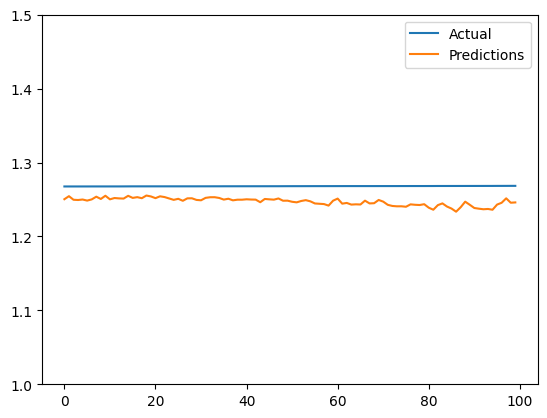

In [26]:
import matplotlib.pyplot as plt

plt.plot(test_df_y, label = "Actual")
plt.plot(y_pred, label = "Predictions")
plt.gca().set_ylim(1, 1.5)
plt.legend()

The above plot shows the difference in values predicted and actual time stamps. Our predictions are quite close if you consider the range of predictions and actual time stamps. However, since these values are time stamps in seconds, this difference which seems small is actually quite large and thus, we might need a more complex model and regularization to reduce the error values further down.

## Task 2: Predicting number of Students for next 100 Events

To predict the number of students, we will use the same variables used before. The neural network architecture and window size will also be the same.

In [27]:
## Extract features and targets from dataset

train_df_num_students = train_df[['Event','Cluster_name','duration','num_students']]
# train_df_num_students_target = train_df[['num_students']]
val_df_num_students = val_df[['Event','Cluster_name','duration','num_students']]
# val_df_num_students_target = val_df[['num_students']]
test_df_num_students = test_df[['Event','Cluster_name','duration','num_students']]
# test_df_num_students_target = test_df[['num_students']]

In [28]:
train_df_X, train_df_y = create_time_series_dataset(train_df_num_students, 50, 1,'num_students')
test_df_X, test_df_y = create_time_series_dataset(test_df_num_students, 50, 1,'num_students')
val_df_X, val_df_y = create_time_series_dataset(val_df_num_students, 50, 1,'num_students')

In [ ]:

multi_lstm_model_num_students = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(50, return_sequences=False),
    # Shape => [batch, out_steps*features].
    # tf.keras.layers.Dense(100*1,
    #                       kernel_initializer=tf.initializers.zeros()),
    # # Shape => [batch, out_steps, features].
    # tf.keras.layers.Reshape([100, 1])
    tf.keras.layers.Dense(1)
])

history = compile_and_fit(multi_lstm_model_num_students, 'multi_lstm_model_num_students')

Epoch 1/20
53803/53803 [==============================] - 282s 5ms/step - loss: 1.2198e-04 - mean_absolute_error: 0.0032 - val_loss: 2.0004e-06 - val_mean_absolute_error: 0.0012
Epoch 2/20
53803/53803 [==============================] - 278s 5ms/step - loss: 4.2364e-06 - mean_absolute_error: 0.0016 - val_loss: 4.8355e-06 - val_mean_absolute_error: 0.0018
Epoch 3/20
53803/53803 [==============================] - 278s 5ms/step - loss: 3.0202e-06 - mean_absolute_error: 0.0014 - val_loss: 1.7871e-06 - val_mean_absolute_error: 0.0011
Epoch 4/20
53803/53803 [==============================] - 278s 5ms/step - loss: 2.4956e-06 - mean_absolute_error: 0.0013 - val_loss: 1.5981e-06 - val_mean_absolute_error: 0.0011
Epoch 5/20
53803/53803 [==============================] - 278s 5ms/step - loss: 2.2238e-06 - mean_absolute_error: 0.0012 - val_loss: 1.9293e-06 - val_mean_absolute_error: 0.0012
Epoch 6/20
53803/53803 [==============================] - 278s 5ms/step - loss: 2.0369e-06 - mean_absolute_err

In [31]:
multi_lstm_model_num_students.load_weights("./lstm_model_multi_lstm_model_num_students.h5")
multi_lstm_model_num_students.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

mse_time, mae_time = multi_lstm_model_num_students.evaluate(test_df_X, test_df_y)

print(f"Mean Squared Error: {mse_time}\n")
print(f"Mean Absolute Error: {mae_time}")


4/4 [==============================] - 0s 5ms/step - loss: 1.1598e-06 - mean_absolute_error: 9.4237e-04
Mean Squared Error: 1.159786847892974e-06

Mean Absolute Error: 0.0009423707379028201


For this task, the mean absolute error and mean square error are significantly better. Let's have a look at the R2 score to further assess the results.

In [32]:
y_pred = multi_lstm_model_num_students.predict(test_df_X)

r2_time = r2_score(test_df_y, y_pred)

print(f"R2 Score: {r2_time}")

4/4 [==============================] - 0s 3ms/step
R2 Score: 0.9654562991398087


R2 score of 0.96 is quite good. It indicates that our model has successfully identified patterns in the dataset and is able to predict values quite close to actual values.

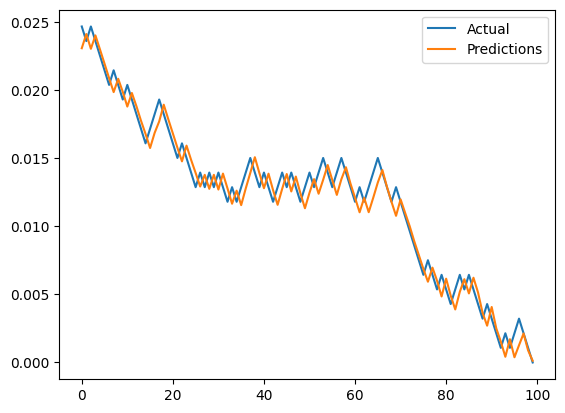

In [33]:
plt.plot(test_df_y, label = "Actual")
plt.plot(y_pred, label = "Predictions")
plt.legend()

The above plot shows how close our predictions are to the actual value. This model performed significantly better than the previous model.

## Task 3: Predicting Cluster names for next 100 Events

For this task, we will make slight modifications to our neural network architecture. Since, we have to predict a categorical variable, we will change the output layer to have number of units equal to the number of classes and add a softmax function to get the probabilities of classes.

In [39]:
## Extract features and targets from dataset

train_df_cluster_name = train_df[['Event', 'duration', 'num_students', 'Cluster_name']]
# train_df_cluster_name_target = train_df[['Cluster_name']]
val_df_cluster_name = val_df[['Event', 'duration', 'num_students', 'Cluster_name']]
# val_df_cluster_name_target = val_df[['Cluster_name']]
test_df_cluster_name = test_df[['Event', 'duration', 'num_students', 'Cluster_name']]
# test_df_cluster_name_target = test_df[['Cluster_name']]

In [41]:
train_df_X, train_df_y = create_time_series_dataset(train_df_cluster_name, 50, 1,'Cluster_name')
test_df_X, test_df_y = create_time_series_dataset(test_df_cluster_name, 50, 1,'Cluster_name')
val_df_X, val_df_y = create_time_series_dataset(val_df_cluster_name, 50, 1,'Cluster_name')

In [42]:
from keras.utils import to_categorical

train_df_y = to_categorical(train_df_y, num_classes = 37)
test_df_y = to_categorical(test_df_y, num_classes = 37)
val_df_y = to_categorical(val_df_y, num_classes = 37)

In [ ]:
import tensorflow as tf

num_classes = len(np.unique(train_df['Cluster_name']))


multi_lstm_model_cluster_name = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(50, return_sequences=False),
    # Shape => [batch, out_steps*features].
    # tf.keras.layers.Dense(100*1,
    #                       kernel_initializer=tf.initializers.zeros()),
    # # Shape => [batch, out_steps, features].
    # tf.keras.layers.Reshape([100, 1])
    tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=4,
                                                    mode='min')

multi_lstm_model_cluster_name.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history = multi_lstm_model_cluster_name.fit(train_df_X, train_df_y, epochs=20,
                      validation_data=(val_df_X, val_df_y),
                      callbacks=[early_stopping])


# history = compile_and_fit(multi_lstm_model_cluster_name, 'multi_lstm_model_cluster_name')

Epoch 1/20
53803/53803 [==============================] - 289s 5ms/step - loss: 3.0786 - accuracy: 0.1436 - val_loss: 3.2549 - val_accuracy: 0.1197
Epoch 2/20
53803/53803 [==============================] - 284s 5ms/step - loss: 3.0364 - accuracy: 0.1486 - val_loss: 3.2413 - val_accuracy: 0.1221
Epoch 3/20
53803/53803 [==============================] - 284s 5ms/step - loss: 3.0189 - accuracy: 0.1504 - val_loss: 3.2289 - val_accuracy: 0.1227
Epoch 4/20
53803/53803 [==============================] - 284s 5ms/step - loss: 3.0082 - accuracy: 0.1520 - val_loss: 3.2258 - val_accuracy: 0.1256
Epoch 5/20
53803/53803 [==============================] - 285s 5ms/step - loss: 3.0008 - accuracy: 0.1525 - val_loss: 3.2119 - val_accuracy: 0.1265
Epoch 6/20
53803/53803 [==============================] - 285s 5ms/step - loss: 2.9955 - accuracy: 0.1531 - val_loss: 3.2234 - val_accuracy: 0.1257
Epoch 7/20
53803/53803 [==============================] - 286s 5ms/step - loss: 2.9915 - accuracy: 0.1534 - val_

In [43]:
num_classes = 37
multi_lstm_model_cluster_name = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(50, input_shape = (50,4), return_sequences=False),
    # Shape => [batch, out_steps*features].
    # tf.keras.layers.Dense(100*1,
    #                       kernel_initializer=tf.initializers.zeros()),
    # # Shape => [batch, out_steps, features].
    # tf.keras.layers.Reshape([100, 1])
    tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

# model_name = "lstm_model_cluster_name"
# multi_lstm_model_cluster_name.save_weights(f'./time_Series/lstm_model_{model_name}.h5')
multi_lstm_model_cluster_name.load_weights("/content/lstm_model_lstm_model_cluster_name.h5")

multi_lstm_model_cluster_name.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

multi_lstm_model_cluster_name.evaluate(test_df_X, test_df_y)

4/4 [==============================] - 1s 6ms/step - loss: 1.4036 - accuracy: 0.3700


[1.403559684753418, 0.3700000047683716]

Our model's accuracy on the validation is set is quite low, just 12%. The performance on the test set is 37%, which is better than validation data. However, the test set only contains 100 data points and considering the nature of our dataset, all cluster names are not included within 100 data points. Hence, the accuracy here is not the true representation of the model's actual performance. Perhaps, the model is not complex enough to understand the trends in the dataset and it might be helpful to add a few more layers and variables to help the model. Due to time and resource constraints, we will leave that to future scope of this project.

In [44]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = multi_lstm_model_cluster_name.predict(test_df_X)

y_pred_class = y_pred.argmax(axis = 1)

cm = classification_report(np.argmax(test_df_y, axis=1), np.argmax(y_pred,axis=1))

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()
print(cm)

4/4 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           9       0.30      0.53      0.38        19
          14       0.00      0.00      0.00         1
          15       0.23      0.10      0.14        31
          24       0.50      0.27      0.35        11
          28       0.44      0.55      0.49        38

    accuracy                           0.37       100
   macro avg       0.29      0.29      0.27       100
weighted avg       0.35      0.37      0.34       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Demo

In [5]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.utils import to_categorical

scaler_duration = MinMaxScaler()
scaler_num_students = MinMaxScaler()
scaler_time_stamp = MinMaxScaler()
scaler_hour = MinMaxScaler()
scaler_minute = MinMaxScaler()
scaler_sec = MinMaxScaler()

label_enc_event = LabelEncoder()
label_enc_cluster = LabelEncoder()
label_enc_day = LabelEncoder()

def scale_encode_data(data_mod, train_data = True):

    data = data_mod.copy()
    if train_data:
        data['duration'] = scaler_duration.fit_transform(data[['duration']])
        data['num_students'] = scaler_num_students.fit_transform(data[['num_students']])
        data['Time_stamp_s'] = scaler_time_stamp.fit_transform(data[['Time_stamp_s']])
        data['Hour'] = scaler_hour.fit_transform(data[['Hour']])
        data['Minute'] = scaler_minute.fit_transform(data[['Minute']])
        data['Second'] = scaler_sec.fit_transform(data[['Second']])

        data['Event'] = label_enc_event.fit_transform(data['Event'])
        data['Cluster_name'] = label_enc_cluster.fit_transform(data['Cluster_name'])
        data['Day'] = label_enc_day.fit_transform(data['Day'])

        return data

    data['duration'] = scaler_duration.transform(data[['duration']])
    data['num_students'] = scaler_num_students.transform(data[['num_students']])
    data['Time_stamp_s'] = scaler_time_stamp.transform(data[['Time_stamp_s']])
    data['Hour'] = scaler_hour.transform(data[['Hour']])
    data['Minute'] = scaler_minute.transform(data[['Minute']])
    data['Second'] = scaler_sec.transform(data[['Second']])

    data['Event'] = label_enc_event.transform(data['Event'])
    data['Cluster_name'] = label_enc_cluster.transform(data['Cluster_name'])
    data['Day'] = label_enc_day.transform(data['Day'])

    return data

def create_time_series_dataset(data, sequence_length, future_steps, col_name):
    sequences = []
    targets = []
    target_df = data[col_name]
    for i in range(len(data) - sequence_length - future_steps + 1):
        sequence = data[i:i + sequence_length]
        target = target_df[i + sequence_length:i + sequence_length + future_steps]
        sequences.append(sequence)
        targets.append(target)

    return np.array(sequences), np.array(targets)

In [6]:
import dateutil.parser
import dateutil.tz

demo_df = pd.read_csv("./TestLog.csv")
demo_df.columns = ["Time_stamp", "Event", "Cluster_name", "duration", "num_students"]
demo_df.head()

## Splitting the time stamp to create additional features

demo_df["Day"] = demo_df["Time_stamp"].apply(lambda x: x.split(' ')[0])
demo_df["Month"] = demo_df["Time_stamp"].apply(lambda x: x.split(' ')[1])
demo_df["Date"] = demo_df["Time_stamp"].apply(lambda x: np.int64(x.split(' ')[2]))
demo_df["Hour"] = demo_df["Time_stamp"].apply(lambda x: np.int64(x.split(' ')[3].split(':')[0]))
demo_df["Minute"] = demo_df["Time_stamp"].apply(lambda x: np.int64(x.split(' ')[3].split(':')[1]))
demo_df["Second"] = demo_df["Time_stamp"].apply(lambda x: np.int64(x.split(' ')[3].split(':')[2]))


## Converting time stamp to consistent format
BST = dateutil.tz.gettz('Europe/London')
# dateutil.parser.parse('25-Oct-20 12:00:00 AM BST', tzinfos={'BST': BST})
demo_df['Time_stamp'] = demo_df['Time_stamp'].apply(lambda x: dateutil.parser.parse(x, tzinfos={'BST': BST}))


## creating target variable by converting time stamp to a number
demo_df['Time_stamp_s'] = demo_df['Time_stamp'].apply(lambda x: pd.Timestamp.timestamp(pd.Timestamp(x)))
demo_df_time = demo_df.set_index('Time_stamp')
demo_df_time.head()

demo_set = demo_df_time.tail(150)
demo_df_time.drop(demo_set.index, inplace = True)
demo_train_df = scale_encode_data(demo_df_time, train_data=True)
test_df = scale_encode_data(demo_set, train_data=False)


test_df_time = test_df[['Cluster_name','num_students', 'duration', 'Time_stamp_s']]
test_df_num_students = test_df[['Event','Cluster_name','duration','num_students']]
test_df_cluster_name = test_df[['Event', 'duration', 'num_students', 'Cluster_name']]


test_df_time_X, test_df_time_y = create_time_series_dataset(test_df_time, 50, 1,'Time_stamp_s')
test_df_num_students_X, test_df_num_students_y = create_time_series_dataset(test_df_num_students, 50, 1,'num_students')
test_df_cluster_name_X, test_df_cluster_name_y = create_time_series_dataset(test_df_cluster_name, 50, 1,'Cluster_name')


test_df_cluster_name_y = to_categorical(test_df_cluster_name_y, num_classes = 37)


In [7]:
test_df_time_X.shape, test_df_time_y.shape

((100, 50, 4), (100, 1))

4/4 [==============================] - 1s 8ms/step - loss: 2.1513e-06 - mean_absolute_error: 0.0014
Mean Squared Error: 2.1513335468625883e-06

Mean Absolute Error: 0.0014261710457503796
4/4 [==============================] - 1s 6ms/step
R2 Score: -0.13697735151277501


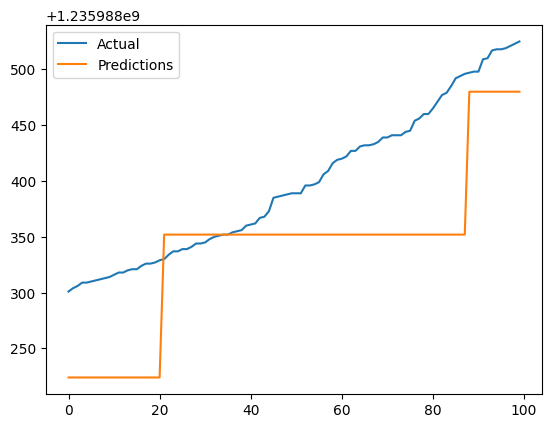

In [8]:
import tensorflow as tf
from sklearn.metrics import r2_score
multi_lstm_model_time = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(50,input_shape = (50,4), return_sequences=False),
    # Shape => [batch, out_steps*features].
    # tf.keras.layers.Dense(100*1,
    #                       kernel_initializer=tf.initializers.zeros()),
    # # Shape => [batch, out_steps, features].
    # tf.keras.layers.Reshape([100, 1])
    tf.keras.layers.Dense(1)
])


multi_lstm_model_time.load_weights("./time_Series/lstm_model_multi_lstm_model_time.h5")
multi_lstm_model_time.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
mse_time, mae_time = multi_lstm_model_time.evaluate(test_df_time_X, test_df_time_y)

print(f"Mean Squared Error: {mse_time}\n")
print(f"Mean Absolute Error: {mae_time}")


y_pred = multi_lstm_model_time.predict(test_df_time_X)

y_pred_inv_scale = scaler_time_stamp.inverse_transform(y_pred)
test_df_y_inv_scale = scaler_time_stamp.inverse_transform(test_df_time_y)

r2_time = r2_score(test_df_y_inv_scale, y_pred_inv_scale)

print(f"R2 Score: {r2_time}")

import matplotlib.pyplot as plt

plt.plot(test_df_y_inv_scale, label = "Actual")
plt.plot(y_pred_inv_scale, label = "Predictions")
# plt.gca().set_ylim(1, 1.5)
plt.legend()



In [9]:
print(f"Actual Timestamp: {pd.to_datetime(test_df_y_inv_scale[0], unit = 's')}")
print(f"Predicted Timestamp: {pd.to_datetime(y_pred_inv_scale[0], unit = 's')}")


Actual Timestamp: DatetimeIndex(['2009-03-02 10:05:01'], dtype='datetime64[ns]', freq=None)
Predicted Timestamp: DatetimeIndex(['2009-03-02 10:03:44'], dtype='datetime64[ns]', freq=None)


4/4 [==============================] - 1s 7ms/step - loss: 3.0289e-05 - mean_absolute_error: 0.0050
Mean Squared Error: 3.0288962079794146e-05

Mean Absolute Error: 0.005046750418841839
4/4 [==============================] - 0s 7ms/step
R2 Score: 0.9151434444692292


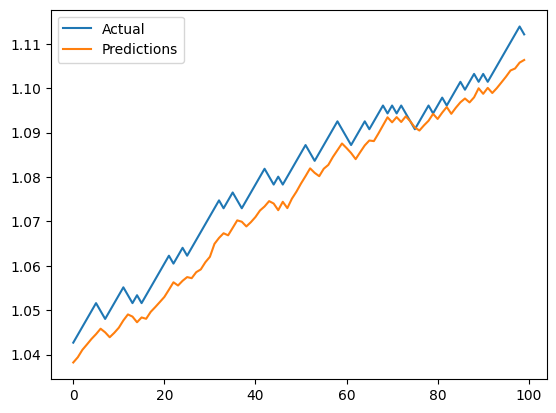

In [10]:
multi_lstm_model_num_students = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(50, input_shape = (50, 4), return_sequences=False),
    # Shape => [batch, out_steps*features].
    # tf.keras.layers.Dense(100*1,
    #                       kernel_initializer=tf.initializers.zeros()),
    # # Shape => [batch, out_steps, features].
    # tf.keras.layers.Reshape([100, 1])
    tf.keras.layers.Dense(1)
])

multi_lstm_model_num_students.load_weights("./time_Series/lstm_model_multi_lstm_model_num_students.h5")
multi_lstm_model_num_students.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

mse_time, mae_time = multi_lstm_model_num_students.evaluate(test_df_num_students_X, test_df_num_students_y)

print(f"Mean Squared Error: {mse_time}\n")
print(f"Mean Absolute Error: {mae_time}")


y_pred = multi_lstm_model_num_students.predict(test_df_num_students_X)

r2_time = r2_score(test_df_num_students_y, y_pred)

print(f"R2 Score: {r2_time}")


plt.plot(test_df_num_students_y, label = "Actual")
plt.plot(y_pred, label = "Predictions")
# plt.gca().set_ylim(1, 1.5)
plt.legend()

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
num_classes = 37
multi_lstm_model_cluster_name = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(50, input_shape = (50,4), return_sequences=False),
    # Shape => [batch, out_steps*features].
    # tf.keras.layers.Dense(100*1,
    #                       kernel_initializer=tf.initializers.zeros()),
    # # Shape => [batch, out_steps, features].
    # tf.keras.layers.Reshape([100, 1])
    tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

# model_name = "lstm_model_cluster_name"
# multi_lstm_model_cluster_name.save_weights(f'./time_Series/lstm_model_{model_name}.h5')
multi_lstm_model_cluster_name.load_weights("./time_Series/lstm_model_lstm_model_cluster_name.h5")

multi_lstm_model_cluster_name.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

multi_lstm_model_cluster_name.evaluate(test_df_cluster_name_X, test_df_cluster_name_y)


y_pred = multi_lstm_model_cluster_name.predict(test_df_cluster_name_X)

y_pred_class = y_pred.argmax(axis = 1)

cm = classification_report(np.argmax(test_df_cluster_name_y, axis=1), np.argmax(y_pred,axis=1))

# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()
print(cm)

4/4 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         6
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.05      0.50      0.09         2
          16       0.00      0.00      0.00         7
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         3
          20       0.00      0.00      0.00         3
          22       0.00      0.00      0.00         1
          24       0.00      0

c:\Users\hrith\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hrith\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hrith\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie